In [177]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from imblearn.combine import SMOTEENN

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "Customer_Data.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "alicanpayasli/customerdata",file_path)

df = df.drop(columns=['Customer_ID'])

/tmp/ipykernel_43427/2739576102.py:19: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "alicanpayasli/customerdata",file_path)


In [178]:
df.describe()

,Age,Annual_Income,Spending_Score,Num_of_Children,Credit_Score,Online_Shopping_Frequency,Target
count,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,43.444767,85053.84060,49.869967,1.997600,574.002467,9.554500,0.304533
std,14.976284,37674.97408,28.775713,1.410081,158.448319,5.806894,0.460217
min,18.000000,20015.00000,1.000000,0.000000,300.000000,0.000000,0.000000
25%,30.000000,52228.00000,25.000000,1.000000,436.000000,4.000000,0.000000
50%,43.000000,84901.00000,50.000000,2.000000,575.000000,10.000000,0.000000
75%,56.000000,117901.25000,75.000000,3.000000,711.000000,15.000000,1.000000
max,69.000000,149999.00000,99.000000,4.000000,849.000000,19.000000,1.000000


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        30000 non-null  int64 
 1   Gender                     30000 non-null  object
 2   Annual_Income              30000 non-null  int64 
 3   Spending_Score             30000 non-null  int64 
 4   Region                     30000 non-null  object
 5   Marital_Status             30000 non-null  object
 6   Num_of_Children            30000 non-null  int64 
 7   Employment_Status          30000 non-null  object
 8   Credit_Score               30000 non-null  int64 
 9   Online_Shopping_Frequency  30000 non-null  int64 
 10  Target                     30000 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 2.5+ MB


In [180]:
df.isnull().sum()

Age                          0
Gender                       0
Annual_Income                0
Spending_Score               0
Region                       0
Marital_Status               0
Num_of_Children              0
Employment_Status            0
Credit_Score                 0
Online_Shopping_Frequency    0
Target                       0
dtype: int64

/tmp/ipykernel_43427/2132845740.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=df, palette='viridis')


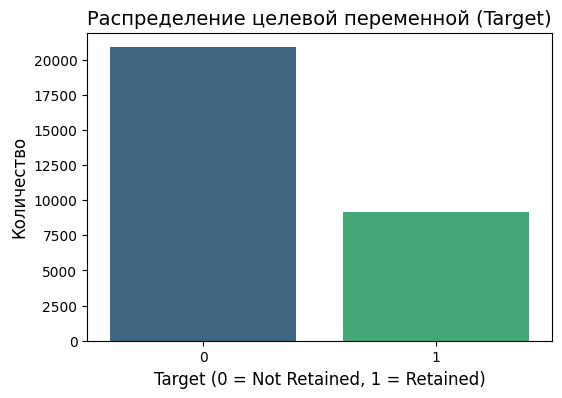

In [181]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df, palette='viridis')
plt.title('Распределение целевой переменной (Target)', fontsize=14)
plt.xlabel('Target (0 = Not Retained, 1 = Retained)', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.show()

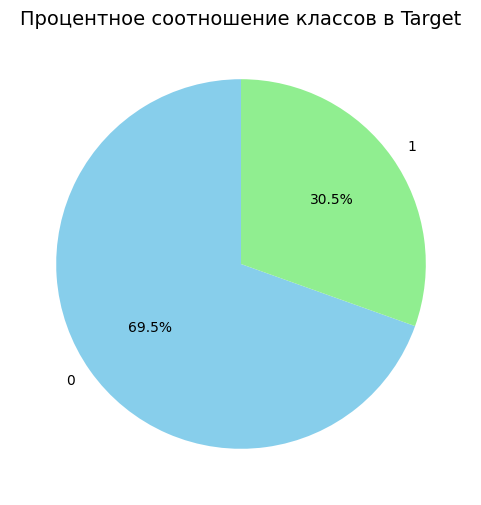

In [182]:
plt.figure(figsize=(6, 6))
df['Target'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90)
plt.title('Процентное соотношение классов в Target', fontsize=14)
plt.ylabel('')
plt.show()

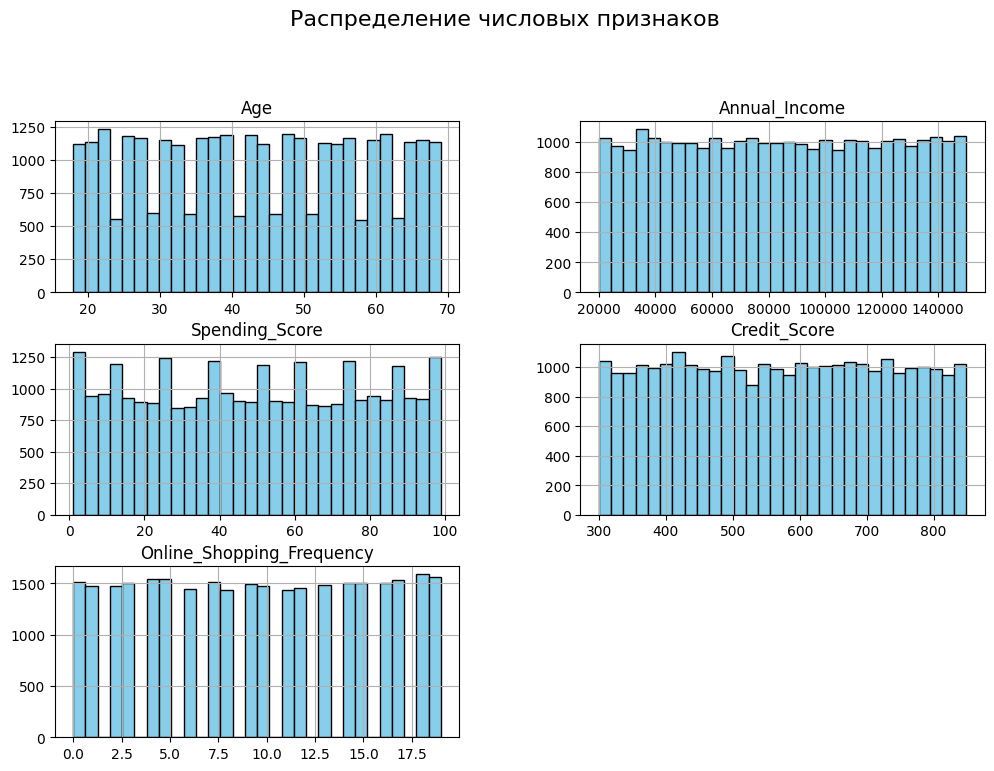

In [183]:
numerical_features = ['Age', 'Annual_Income', 'Spending_Score', 'Credit_Score', 'Online_Shopping_Frequency']
df[numerical_features].hist(figsize=(12, 8), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Распределение числовых признаков', fontsize=16, y=1.02)
plt.show()

/tmp/ipykernel_43427/2050164984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y=feature, data=df, palette='viridis')
/tmp/ipykernel_43427/2050164984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y=feature, data=df, palette='viridis')
/tmp/ipykernel_43427/2050164984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y=feature, data=df, palette='viridis')
/tmp/ipykernel_43427/2050164984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.

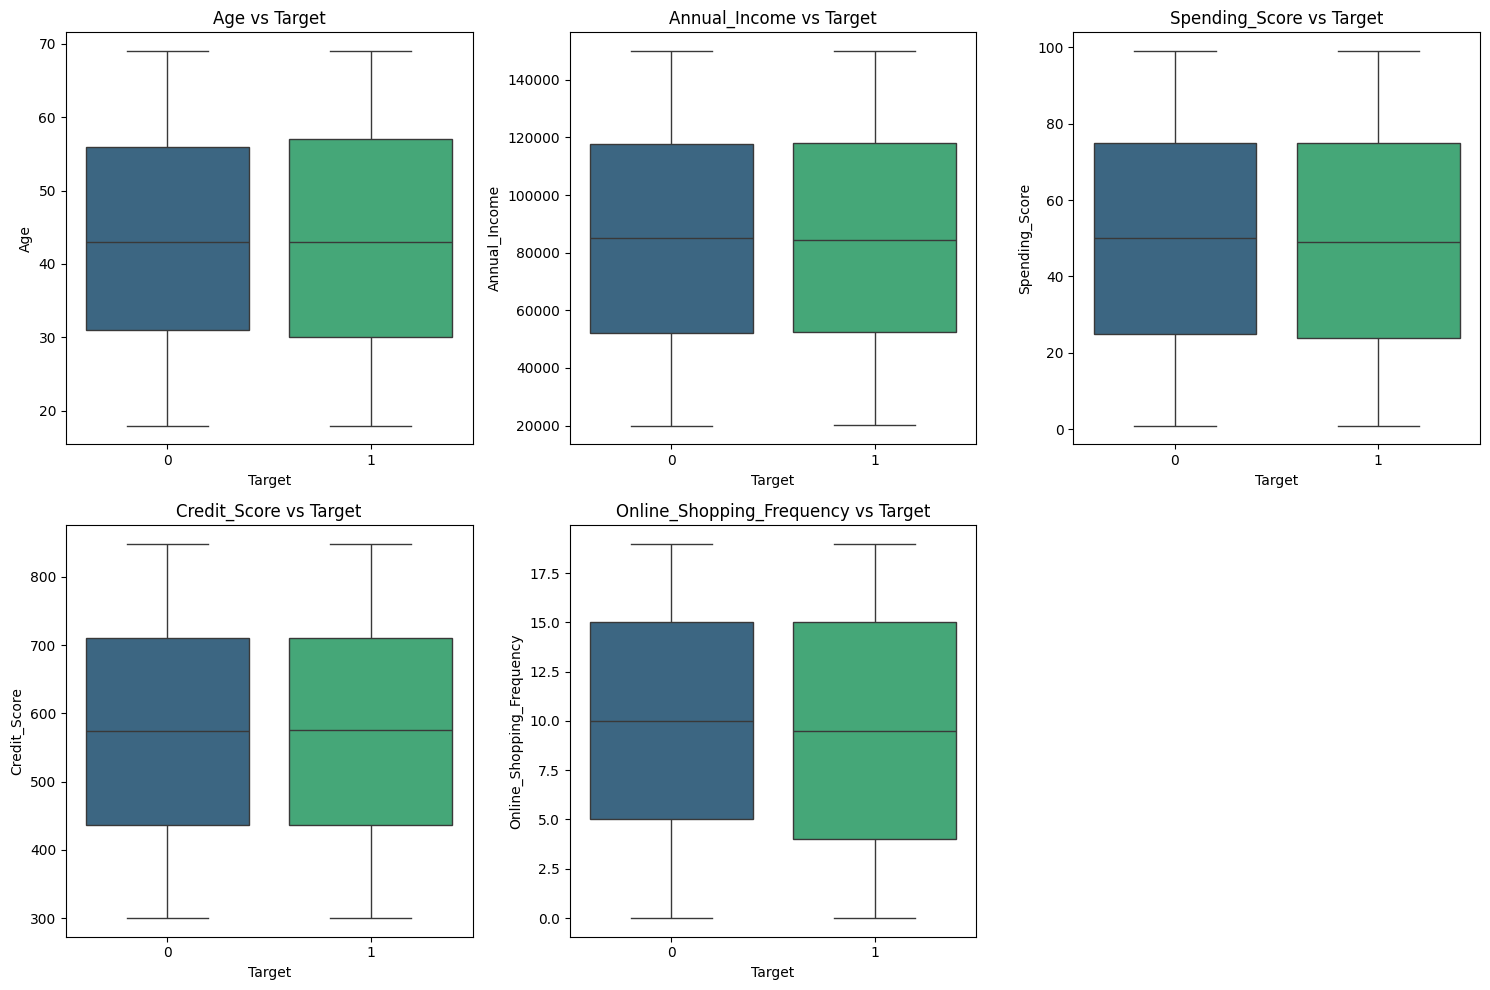

In [184]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Target', y=feature, data=df, palette='viridis')
    plt.title(f'{feature} vs Target', fontsize=12)
    plt.xlabel('Target', fontsize=10)
    plt.ylabel(feature, fontsize=10)
plt.tight_layout()
plt.show()

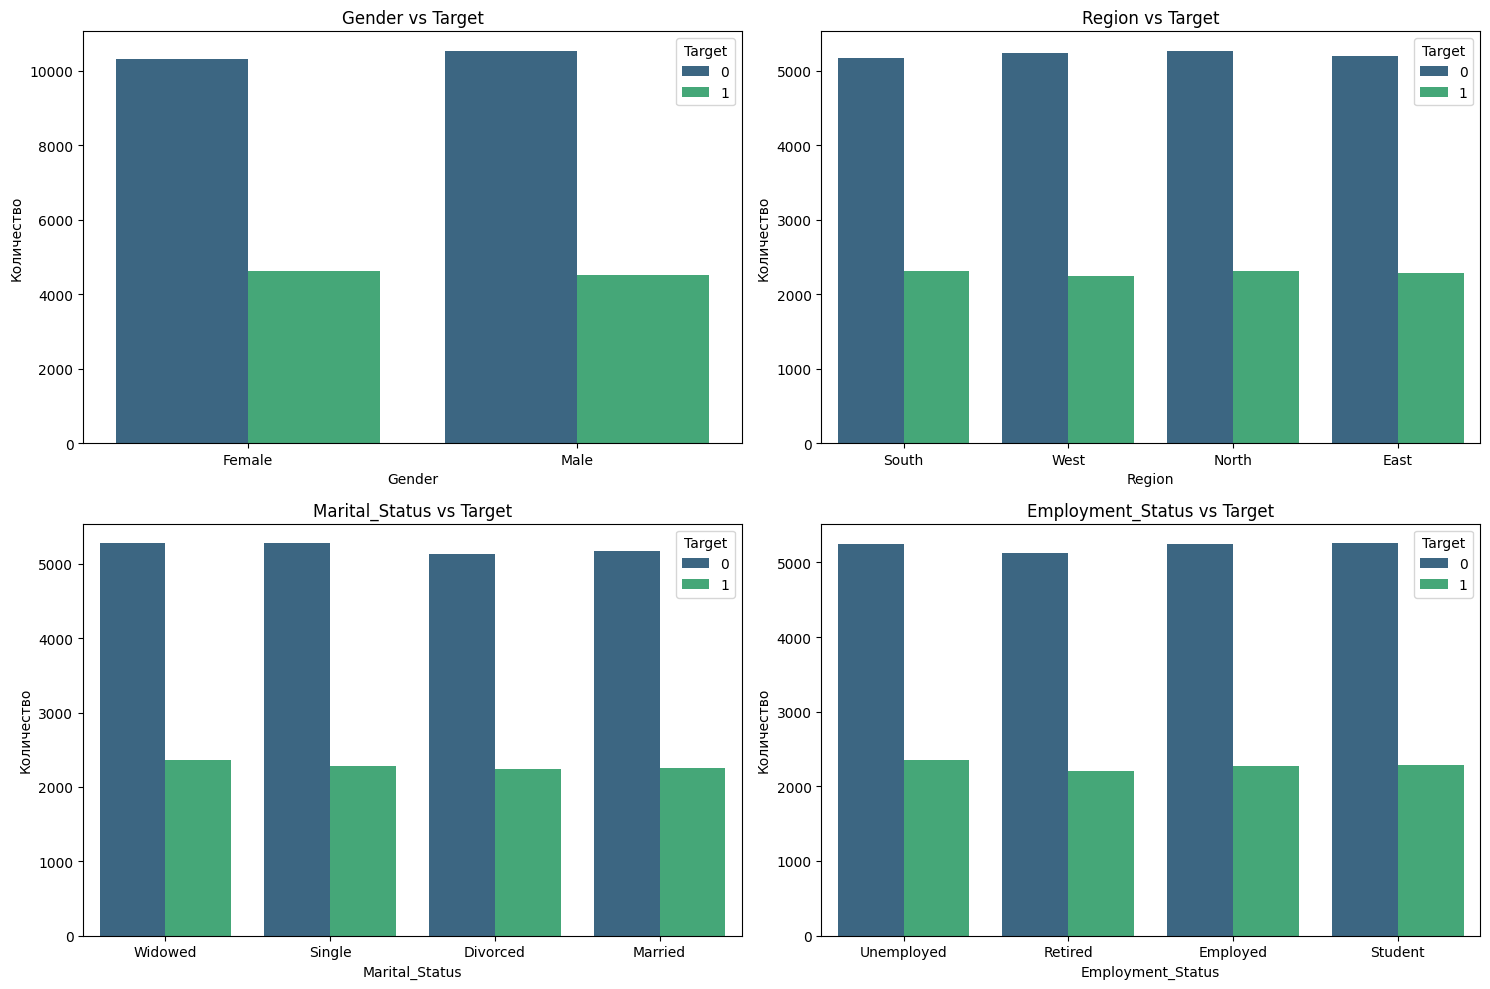

In [185]:
categorical_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=feature, hue='Target', data=df, palette='viridis')
    plt.title(f'{feature} vs Target', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Количество', fontsize=10)
    plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

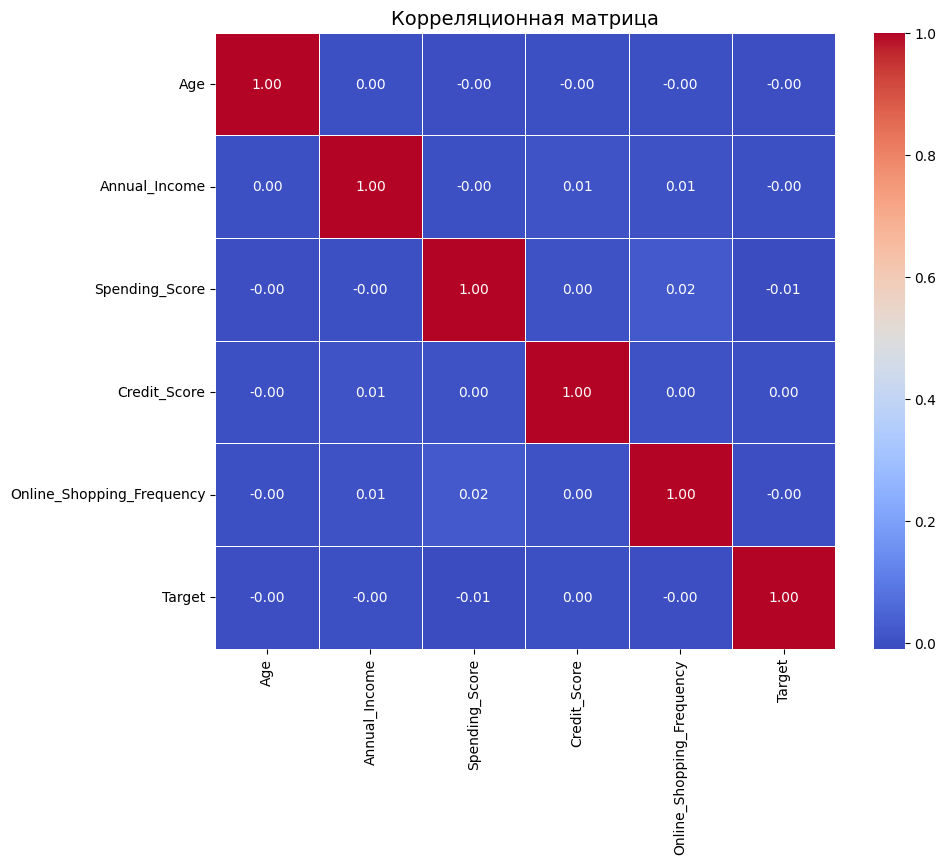

In [186]:
correlation_matrix = df[numerical_features + ['Target']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица', fontsize=14)
plt.show()

In [187]:
# sns.pairplot(df, vars=numerical_features, hue='Target', palette='viridis', diag_kind='kde', height=3)
# plt.suptitle('Pairplot числовых признаков', fontsize=16, y=1.02)
# plt.show()

In [188]:
# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(categorical_features, 1):
#     plt.subplot(2, 2, i)
#     sns.violinplot(x=feature, y='Spending_Score', hue='Target', data=df, split=True, palette='viridis')
#     plt.title(f'{feature} vs Spending_Score', fontsize=12)
#     plt.xlabel(feature, fontsize=10)
#     plt.ylabel('Spending_Score', fontsize=10)
# plt.tight_layout()
# plt.show()

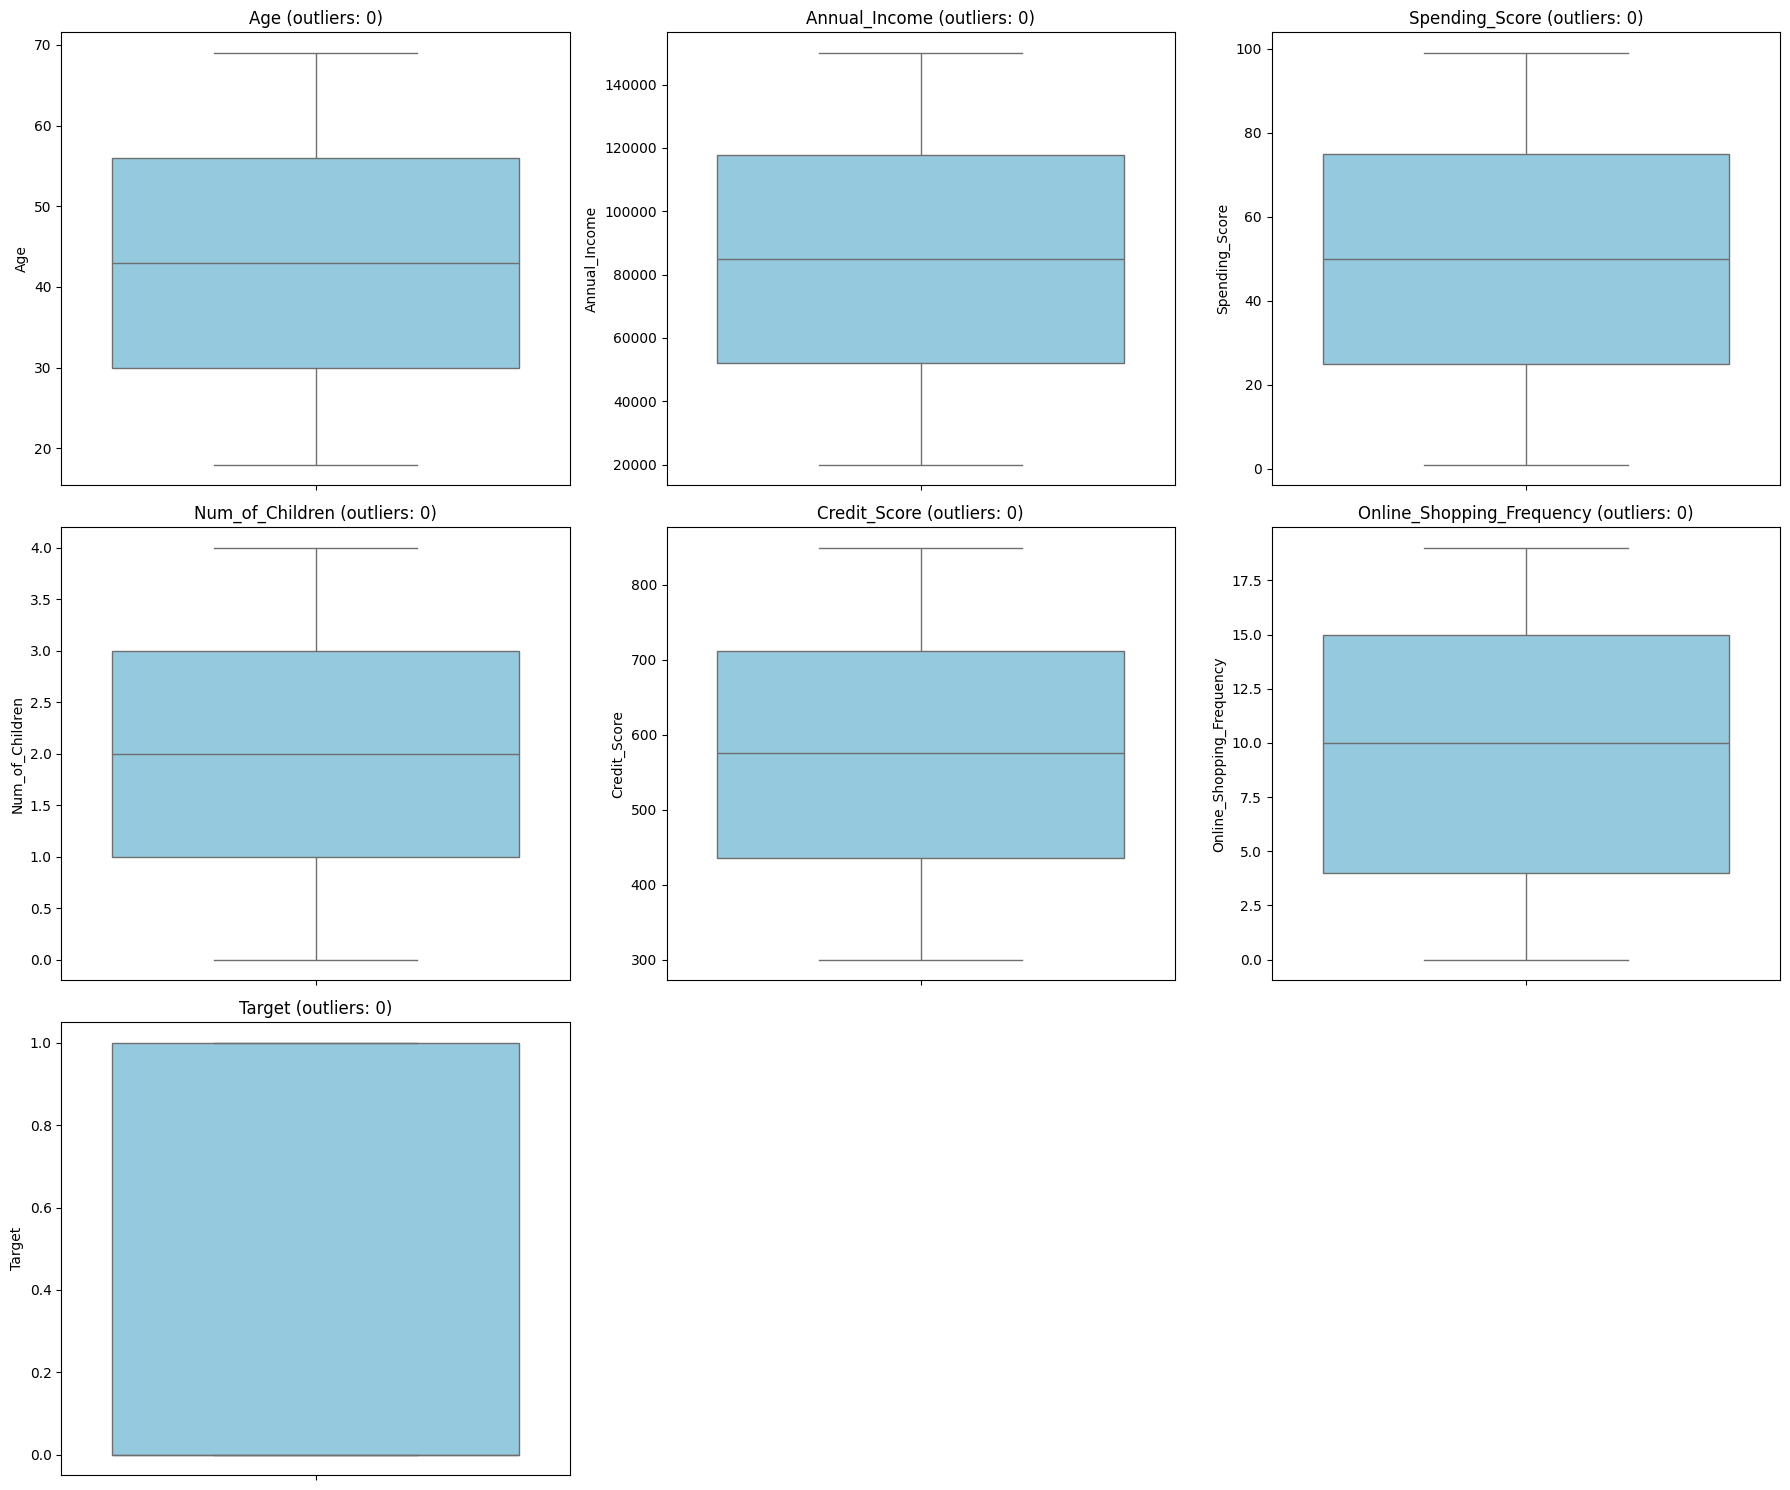

In [189]:
def detect_and_plot_outliers_iqr(df):
    outliers_summary = {}

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    num_cols = len(numeric_cols)
    ncols = 3
    nrows = (num_cols + ncols - 1) // ncols
    plt.figure(figsize=(6 * ncols, 5 * nrows))

    for i, col in enumerate(numeric_cols, 1):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Найдём выбросы
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_percent = 100 * outlier_count / df.shape[0]

        # Добавим в отчёт
        outliers_summary[col] = {
            'count': outlier_count,
            'percent': round(outlier_percent, 2),
            'indices': outliers.index.tolist()
        }

        # График
        plt.subplot(nrows, ncols, i)
        sns.boxplot(y=df[col], color="skyblue", fliersize=5)
        plt.title(f"{col} (outliers: {outlier_count})")

    plt.tight_layout()
    plt.show()


detect_and_plot_outliers_iqr(df)


In [190]:

TARGET_COL = 'Target'
df_clean = df.copy()

df_clean['Spending_to_Income_Ratio'] = df_clean['Spending_Score'] / df_clean['Annual_Income']
df_clean['Age_to_Spending_Ratio'] = df_clean['Age'] / (df_clean['Spending_Score'] + 1)
df_clean['Avg_Spending_Per_Online_Order'] = df_clean['Spending_Score'] / (df_clean['Online_Shopping_Frequency'] + 1)
df_clean['Online_Shopping_Frequency_Per_Age'] = df_clean['Online_Shopping_Frequency'] / df_clean['Age']
df_clean['Log_Annual_Income'] = np.log1p(df_clean['Annual_Income'])
df_clean['Credit_Score_to_Age'] = df_clean['Credit_Score'] / df_clean['Age']

numeric_features = ['Age', 'Annual_Income', 'Spending_Score', 'Credit_Score', 'Online_Shopping_Frequency'] + ['Spending_to_Income_Ratio',  'Age_to_Spending_Ratio', 'Avg_Spending_Per_Online_Order', 'Online_Shopping_Frequency_Per_Age', 'Credit_Score_to_Age']

categorical_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']

X_num = df_clean.select_dtypes(exclude='object')
X_cat = df_clean.select_dtypes(include='object')
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_cat)
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in encoder.categories_[i]]

one_hot_features = pd.DataFrame(X_encoded, columns=categorical_columns)

df_clean = X_num.join(one_hot_features)


/home/vtumanovskiy/web/otus/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [191]:
from imblearn.over_sampling import ADASYN

data = df_clean.copy()

X = data.drop(['Target'], axis=1)
y = data['Target']

adasyn = ADASYN(sampling_strategy=0.8)
X_bal, y_bal = adasyn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

X = data.drop(columns=['Target'])
y = data['Target']

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82      4173
           1       0.95      0.48      0.63      3358

    accuracy                           0.75      7531
   macro avg       0.82      0.73      0.72      7531
weighted avg       0.81      0.75      0.73      7531


Confusion Matrix:
[[4083   90]
 [1759 1599]]

ROC-AUC Score: 0.7377436088687781


In [192]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier

data = df_clean.copy()

X = data.drop([TARGET_COL], axis=1)
y = data[TARGET_COL]

smote_enn = SMOTEENN(sampling_strategy='auto')
X_comb, y_comb = smote_enn.fit_resample(X, y)

# smote = SMOTE(random_state=42)
# X_comb, y_comb = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_comb, y_comb, test_size=0.2, random_state=42, stratify=y_comb
)


preprocessor = ColumnTransformer(
    transformers=[
        # ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    verbose=50,
    random_seed=42,
    auto_class_weights='Balanced',
)

clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

0:	total: 12.5ms	remaining: 6.24s
50:	total: 287ms	remaining: 2.53s
100:	total: 409ms	remaining: 1.62s
150:	total: 528ms	remaining: 1.22s
200:	total: 657ms	remaining: 978ms
250:	total: 785ms	remaining: 778ms
300:	total: 902ms	remaining: 597ms
350:	total: 1.02s	remaining: 433ms
400:	total: 1.15s	remaining: 283ms
450:	total: 1.26s	remaining: 137ms
499:	total: 1.38s	remaining: 0us
Confusion Matrix:
[[ 855  298]
 [ 550 1385]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1153
           1       0.82      0.72      0.77      1935

    accuracy                           0.73      3088
   macro avg       0.72      0.73      0.72      3088
weighted avg       0.74      0.73      0.73      3088


ROC AUC Score: 0.8062418900475335


In [193]:
data = df_clean.copy()

X = data.drop([TARGET_COL], axis=1)
y = data[TARGET_COL]

# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

smote_enn = SMOTE(sampling_strategy='auto')
X_comb, y_comb = smote_enn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=0.2, random_state=42, stratify=y_comb)

X = data.drop(columns=[TARGET_COL])
y = data[TARGET_COL]

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      4173
           1       0.95      0.60      0.73      4173

    accuracy                           0.78      8346
   macro avg       0.83      0.78      0.78      8346
weighted avg       0.83      0.78      0.78      8346


Confusion Matrix:
[[4046  127]
 [1677 2496]]

ROC-AUC Score: 0.8014199437703002


In [ ]:
from xgboost import XGBClassifier

data = df_clean.copy()

X = data.drop([TARGET_COL], axis=1)
y = data[TARGET_COL]

# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

smote_enn = SMOTEENN(sampling_strategy='auto')
X_comb, y_comb = smote_enn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=0.2, random_state=42, stratify=y_comb)

X = data.drop(columns=[TARGET_COL])
y = data[TARGET_COL]

xgb = XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.87      0.75      1159
           1       0.90      0.73      0.81      1914

    accuracy                           0.78      3073
   macro avg       0.78      0.80      0.78      3073
weighted avg       0.81      0.78      0.79      3073


Confusion Matrix:
[[1009  150]
 [ 511 1403]]

ROC-AUC Score: 0.8478122692516791


In [ ]:
data = df_clean.copy()

X = data.drop([TARGET_COL], axis=1)
y = data[TARGET_COL]

# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

smote_enn = SMOTEENN(sampling_strategy='auto')
X_comb, y_comb = smote_enn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=0.2, random_state=42, stratify=y_comb)

X = data.drop(columns=[TARGET_COL])
y = data[TARGET_COL]

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

data = df_clean.copy()

X = data.drop(columns=[TARGET_COL])
y = data[TARGET_COL]

smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_comb, y_comb = smote_enn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_comb, y_comb, test_size=0.2, random_state=42, stratify=y_comb
)

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1
)
catboost = CatBoostClassifier(
    iterations=100,
    random_seed=42,
    verbose=0,
    class_weights=None
)

estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('catboost', catboost)
]
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    cv=5
)

stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)
y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

/home/vtumanovskiy/web/otus/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:22:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vtumanovskiy/web/otus/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:22:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vtumanovskiy/web/otus/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:22:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vtumanovskiy/web/otus/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:22:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vt

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.80      0.71      1148
           1       0.86      0.73      0.79      1885

    accuracy                           0.76      3033
   macro avg       0.75      0.76      0.75      3033
weighted avg       0.78      0.76      0.76      3033


Confusion Matrix:
[[ 919  229]
 [ 514 1371]]

ROC-AUC Score: 0.8302648360890582
